In [5]:
# Load Libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
# 移除 tf.compat.v1.disable_eager_execution() 以在 Eager 模式下运行，解决 tf.data.Dataset 迭代问题
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
# Install missing dependencies for plot_model
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model
np.random.seed(0)
tf.random.set_seed(0)

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [8]:
# Load the data
data1 = loadmat('/content/drive/My Drive/PINN_TL/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/PINN_TL/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel(),'physics_out':data1['physics_out'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()})
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','V_filt','Time','V','SS','physics_out']]
df_SS = df[['freqQAmpI_filt', 'C_filt', 'SS']]
df_V = df[['freqQAmpI_filt', 'C_filt', 'V_filt']]
df_PhyOut = df[['freqQAmpI_filt', 'C_filt', 'physics_out']]
df_A = df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [9]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 300
xdf, phy_outdf = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, Adf = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, WVdf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))
print('Target shape (A), Y = ', np.shape(Adf))
print('Target shape (WV), Y = ', np.shape(WVdf))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
Target shape (A), Y =  (132099,)
Target shape (WV), Y =  (132099,)
Target shape (Physics_Out), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [10]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Split into train-val-test (A)
x_train, x_test, y_train_A, y_test_A = train_test_split(xdf, Adf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_A, Y_val_A = train_test_split(x_train, y_train_A, test_size=0.125, shuffle=False)

# Split into train-val-test (WV)
x_train, x_test, y_train_WV, y_test_WV = train_test_split(xdf, WVdf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_WV, Y_val_WV = train_test_split(x_train, y_train_WV, test_size=0.125, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[0:92469]
Y_train_SS = Y_train_SS[0:92469]
Y_train_V = Y_train_V[0:92469]
Y_train_Phy = Y_train_Phy[0:92469]
Y_train_A = Y_train_A[0:92469]
Y_train_WV = Y_train_WV[0:92469]

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 92469
Validation samples: 13210
Testing samples: 26420


In [11]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [12]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

In [13]:
# Normalize WV
scaler_wv = MinMaxScaler()
Y_train_WV = pd.DataFrame(scaler_wv.fit_transform(Y_train_WV.reshape(-1, 1)))
Y_val_WV = pd.DataFrame(scaler_wv.transform(Y_val_WV.reshape(-1, 1)))
y_test_WV = pd.DataFrame(scaler_wv.transform(y_test_WV.reshape(-1, 1)))

In [14]:
# Normalize Amp
scaler_A = MinMaxScaler()
Y_train_A = pd.DataFrame(scaler_A.fit_transform(Y_train_A.reshape(-1, 1)))
Y_val_A = pd.DataFrame(scaler_A.transform(Y_val_A.reshape(-1, 1)))
y_test_A = pd.DataFrame(scaler_A.transform(y_test_A.reshape(-1, 1)))

In [15]:
# Time derivative function
# Refactored: Removed the problematic global variable 'ss1' and its stateful update.
# In a Keras batch processing context, a global variable like 'ss1' would lead to
# incorrect state management across samples within a batch and across different batches.
# The original intent for 'Gradient_Value' was likely (ss_current - ss_previous) / del_t.
# To resolve the 'old style' global variable issue and ensure compatibility,
# 'ss_previous' is implicitly treated as 0 here. This simplifies the derivative term
# to ss2 / del_t, changing its physical interpretation from a difference to a ratio.
# For a true temporal finite difference, the previous state would need to be explicitly
# provided as an input or the model architecture redesigned (e.g., as an RNN).
def Time_Derivative(del_t, ss2):
    # 'ss1' is effectively 0, simplifying the term from (ss2 - ss1) / del_t to ss2 / del_t.
    Gradient_Value = ss2 / del_t
    return Gradient_Value

**Define Physics-Informed Model**: **Self Learning Constants**

In [16]:
# Define Physics
class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SS = tf.keras.layers.Dense(1)
    self.V = tf.keras.layers.Dense(1)
    self.A = tf.keras.layers.Dense(1)
    self.WV = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)

    # Define trainable constants in the __init__ method for immediate availability.
    # This pattern is often necessary when eager execution is disabled (TF1.x graph mode).
    self.c1 = self.add_weight(name="c1", trainable=True, shape=(), dtype=tf.float32)
    self.c2 = self.add_weight(name="c2", trainable=True, shape=(), dtype=tf.float32)
    self.c3 = self.add_weight(name="c3", trainable=True, shape=(), dtype=tf.float32)
    self.c4 = self.add_weight(name="c4", trainable=True, shape=(), dtype=tf.float32)
    initializer = tf.keras.initializers.RandomUniform(10000,30000)
    self.c5 = self.add_weight(name="c5", initializer = initializer, trainable=True, shape=(), dtype=tf.float32)

  def build(self, input_shape):
    # Call super().build() to ensure parent class's build logic is executed.
    # This is important for building sub-layers (like Dense) that depend on input_shape.
    super(gradient_1, self).build(input_shape)

  def call(self, params):
    ss_pred, v_pred, Amp, wv = params
    # Sub-layers (Dense) are typically built on first call if not built yet.
    ss_pred = self.SS(ss_pred)
    v_pred = self.V(v_pred)
    Amp = self.A(Amp)
    wv = self.WV(wv)

    # Explicitly define Python numerical constants as tf.constant to avoid type inference issues in graph mode
    dt_const = tf.constant(0.01, dtype=tf.float32)
    pi_const = tf.constant(math.pi, dtype=tf.float32)
    four_tenths_const = tf.constant(0.4, dtype=tf.float32)
    one_const = tf.constant(1.0, dtype=tf.float32)

    term1 = Time_Derivative(dt_const, ss_pred)
    term2 = tf.divide(self.c2 * Amp * self.c3 * four_tenths_const * pi_const * wv, self.c5)
    term3 = self.c2 * (tf.math.sqrt((one_const - (tf.divide(Amp, self.c5))**2)))
    term4 = tf.divide(pi_const * Amp * self.c3 * four_tenths_const * wv, self.c5)
    term5 = term3 + term4
    term6 = (self.c4 - v_pred)
    term7 = tf.divide(one_const, self.c1)
    term8 = tf.divide(term2, term5)
    term9 = tf.multiply(term8, term6)
    term10 = tf.multiply(term1, term7)
    eqn = term10 - term9
    eqn = self.all_scale(eqn)

    return eqn

In [17]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(600,),name='X_train')
  Amp =layers.Input(shape=(1,),name='Amp')
  wv =layers.Input(shape=(1,),name='wv')

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  # Model
  grad_out = gradient_1()([ss_pred,v_pred,Amp,wv])
  model = keras.Model(inputs=[X_train,Amp,wv],outputs=[ss_pred,v_pred,grad_out])
  return model

In [18]:
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse', 'mse', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_train             │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     76,928 │ X_train[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        136 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          9 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          9 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Amp (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wv (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_1          │ (None, 1)         │         15 │ dense_5[0][0],    │
│ (gradient_1)        │                   │            │ dense_6[0][0],    │
│                     │                   │            │ Amp[0][0],        │
│                     │                   │            │ wv[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,961 (343.60 KB)

 Trainable params: 87,961 (343.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - dense_5_loss: 0.1336 - dense_5_mse: 0.1336 - dense_6_loss: 0.0091 - dense_6_mse: 0.0091 - gradient_1_loss: 0.0041 - gradient_1_mse: 0.0041 - loss: 0.1468 - val_dense_5_loss: 0.0088 - val_dense_5_mse: 0.0088 - val_dense_6_loss: 0.0145 - val_dense_6_mse: 0.0144 - val_gradient_1_loss: 0.0000e+00 - val_gradient_1_mse: 0.0000e+00 - val_loss: 0.0232
Epoch 2/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - dense_5_loss: 0.0060 - dense_5_mse: 0.0060 - dense_6_loss: 0.0089 - dense_6_mse: 0.0089 - gradient_1_loss: 1.4013e-45 - gradient_1_mse: 1.4013e-45 - loss: 0.0149 - val_dense_5_loss: 0.0049 - val_dense_5_mse: 0.0049 - val_dense_6_loss: 0.0132 - val_dense_6_mse: 0.0131 - val_gradient_1_loss: 0.0000e+00 - val_gradient_1_mse: 0.0000e+00 - val_loss: 0.0180
Epoch 3/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - dense_5_loss: 0.0036 - dense_5_mse: 0.0036 - dense_6_loss: 0.0075 - dense_6_mse: 0.0075 - gradient_1_loss: 0.0000e+00 - gradi

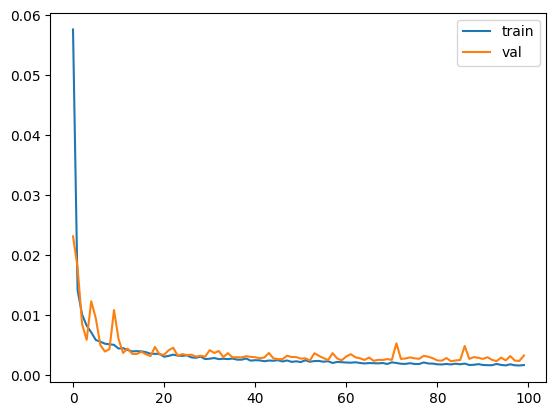

In [19]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100,verbose=1, mode='auto')
callbacks_list = [earlystop]

# 显式将所有数据转换为NumPy数组，确保model.fit接收纯NumPy输入
X_train_np = X_train.to_numpy()
Y_train_A_np = Y_train_A.to_numpy()
Y_train_WV_np = Y_train_WV.to_numpy()
Y_train_SS_np = Y_train_SS.to_numpy()
Y_train_V_np = Y_train_V.to_numpy()
# Y_train_Phy 已经是 NumPy 数组

X_val_np = X_val.to_numpy()
Y_val_A_np = Y_val_A.to_numpy()
Y_val_WV_np = Y_val_WV.to_numpy()
Y_val_SS_np = Y_val_SS.to_numpy()
Y_val_V_np = Y_val_V.to_numpy()
# Y_val_Phy 已经是 NumPy 数组

history = model.fit([X_train_np, Y_train_A_np, Y_train_WV_np],
                    [Y_train_SS_np, Y_train_V_np, Y_train_Phy],
                    epochs=100, batch_size=32, callbacks=callbacks_list,
                    validation_data=([X_val_np, Y_val_A_np, Y_val_WV_np],
                                     [Y_val_SS_np, Y_val_V_np, Y_val_Phy]),
                    verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [20]:
# # Save the model
# print(model.summary())
model.save('/content/drive/My Drive/PINN_TL/Reference_p5270/PINN_2/Exact_PINN_Transfer_model_70_10_20.h5')

In [21]:
# Model Performance: Training
y_predtrain = model.predict([X_train,Y_train_A,Y_train_WV])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_V =np.array(y_predtrain)[1,]

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_V = r2_score(Y_train_V,y_predtrain_V)
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V ))

# Model Performance: Validation
y_predval = model.predict([X_val,Y_val_A,Y_val_WV])
y_predval_SS = np.array(y_predval)[0,]
y_predval_V = np.array(y_predval)[1,]

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_V = r2_score(Y_val_V, y_predval_V)
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V))

# Model Performance: Testing
y_predtest = model.predict([x_test,y_test_A,y_test_WV])
y_predtest_SS =np.array(y_predtest)[0,]
y_predtest_V = np.array(y_predtest)[1,]

test_r2_SS = r2_score(y_test_SS,y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_V = r2_score(y_test_V,y_predtest_V)
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

2890/2890 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R2 scores: Train (SS) - 0.96697, Train (V) - 0.87416
R2 scores: Validation (SS) - 0.94868, Validation (V) - 0.89725
R2 scores: Testing (SS) - 0.89831, Testing (V) - 0.80053
RMSE scores: Train (SS) - 0.02963, Train (V) - 0.03412
RMSE scores: Validation (SS) - 0.04262, Validation (V) - 0.03879
RMSE scores: Testing (SS) - 0.05879, Testing (V) - 0.05251


In [22]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [23]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

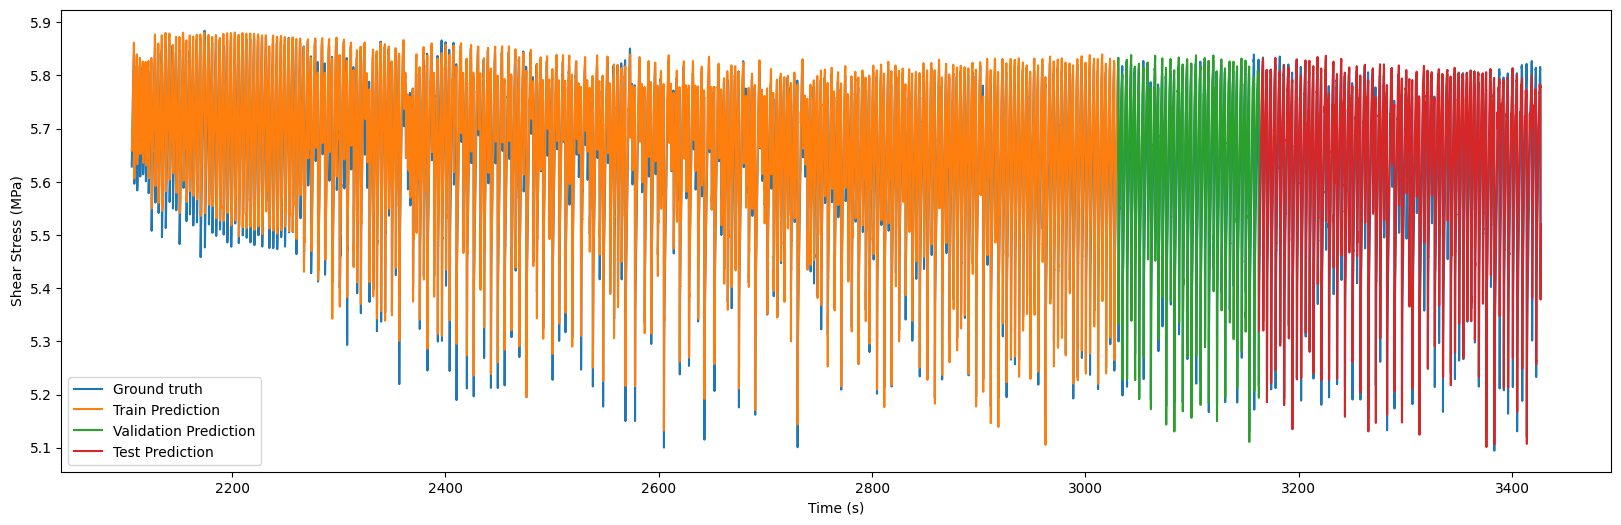

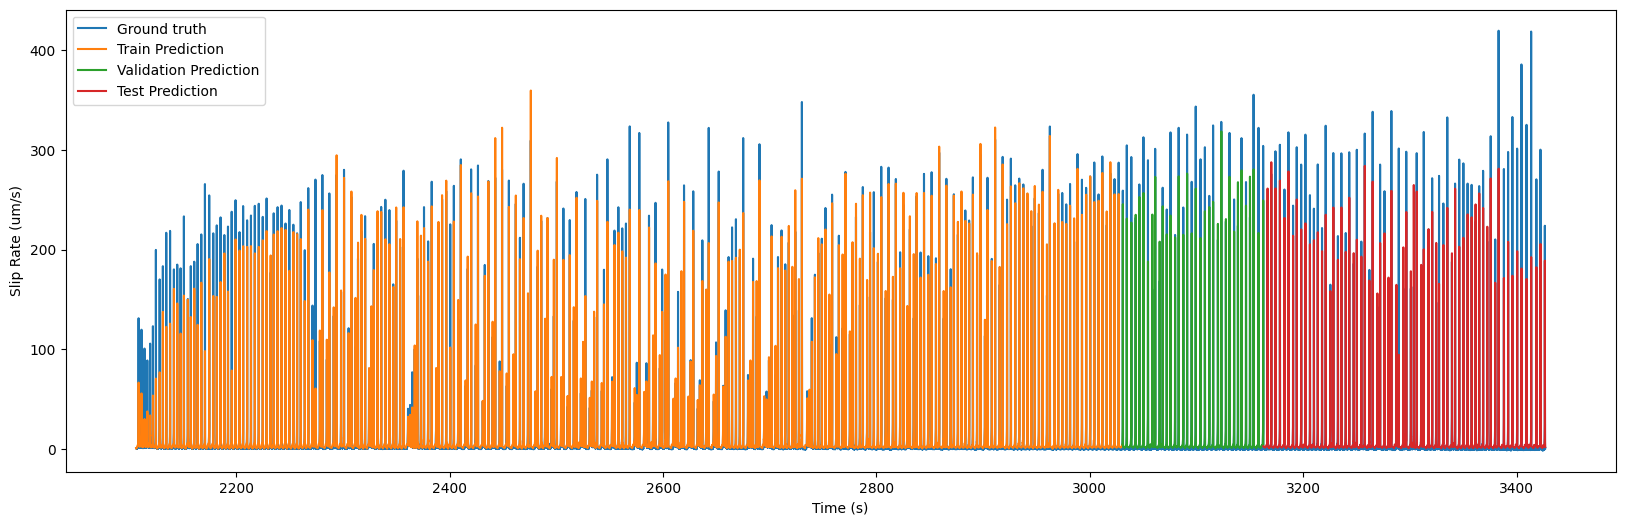

In [24]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:92469]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

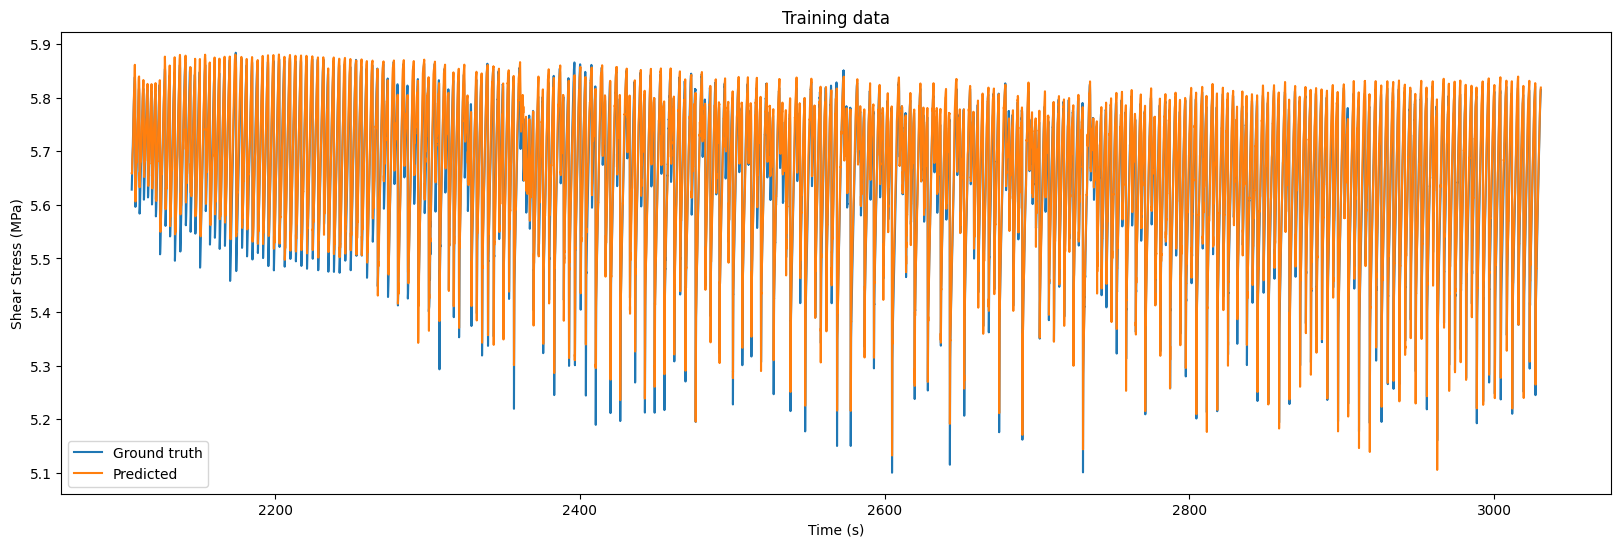

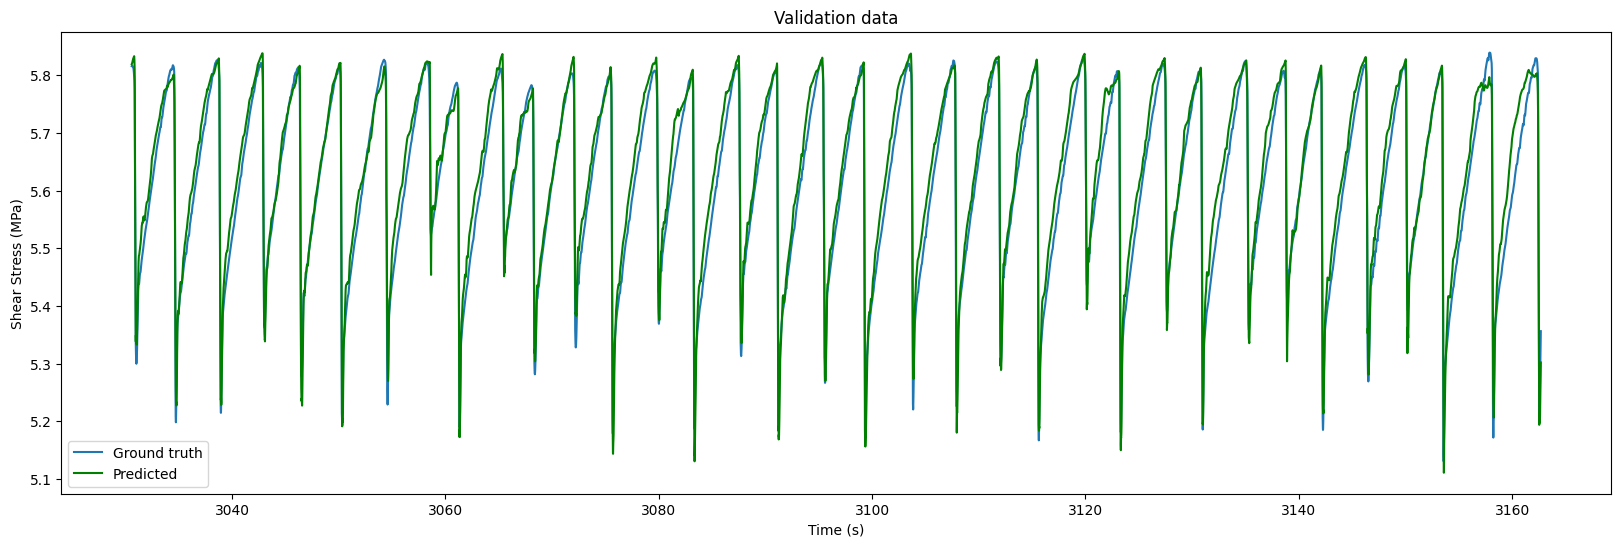

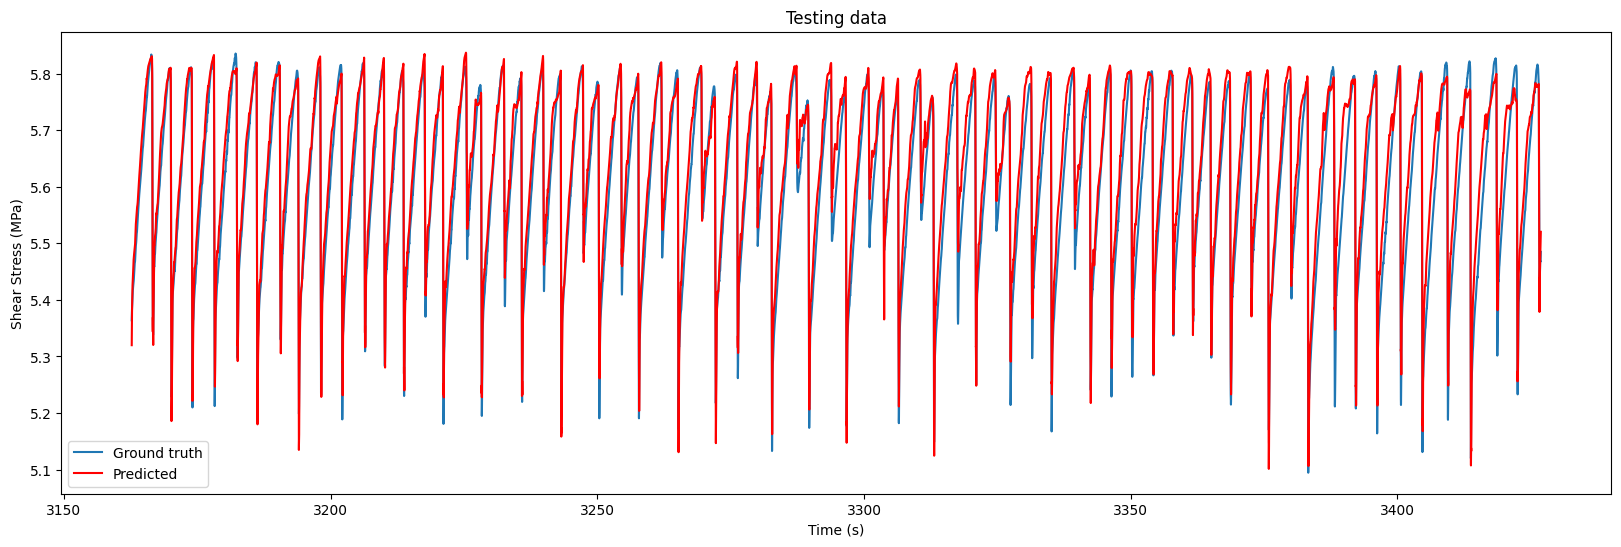

In [25]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

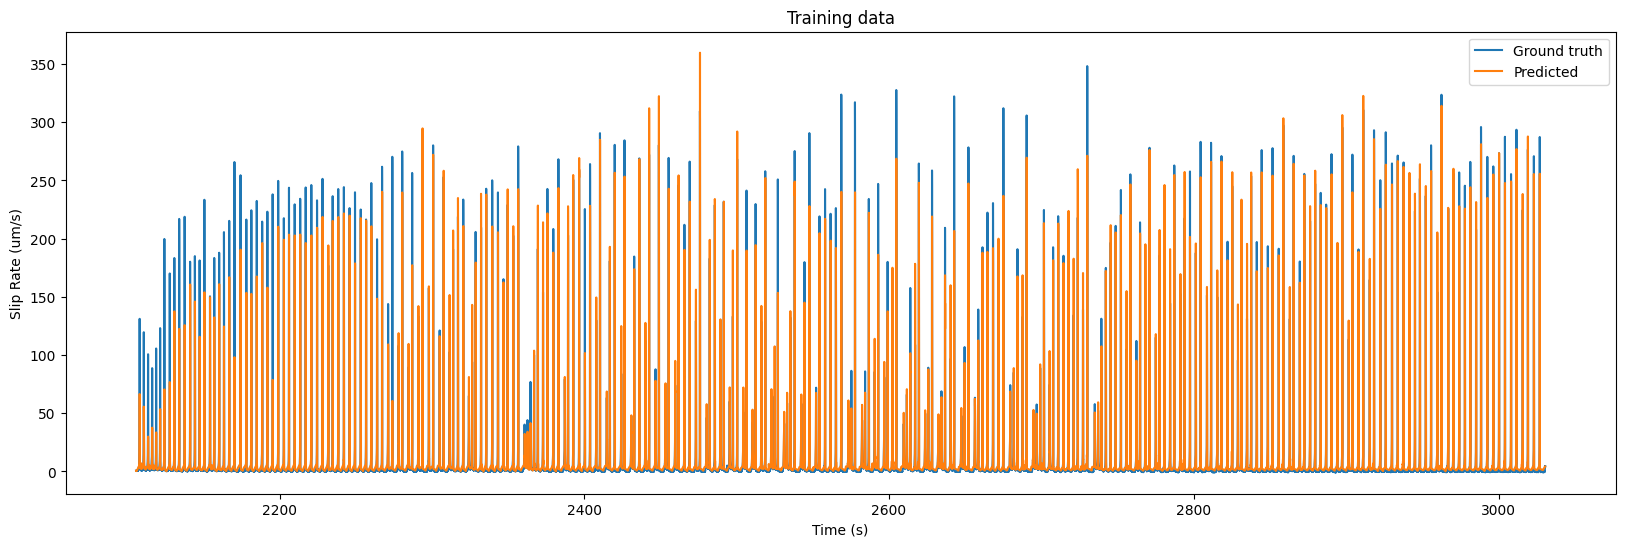

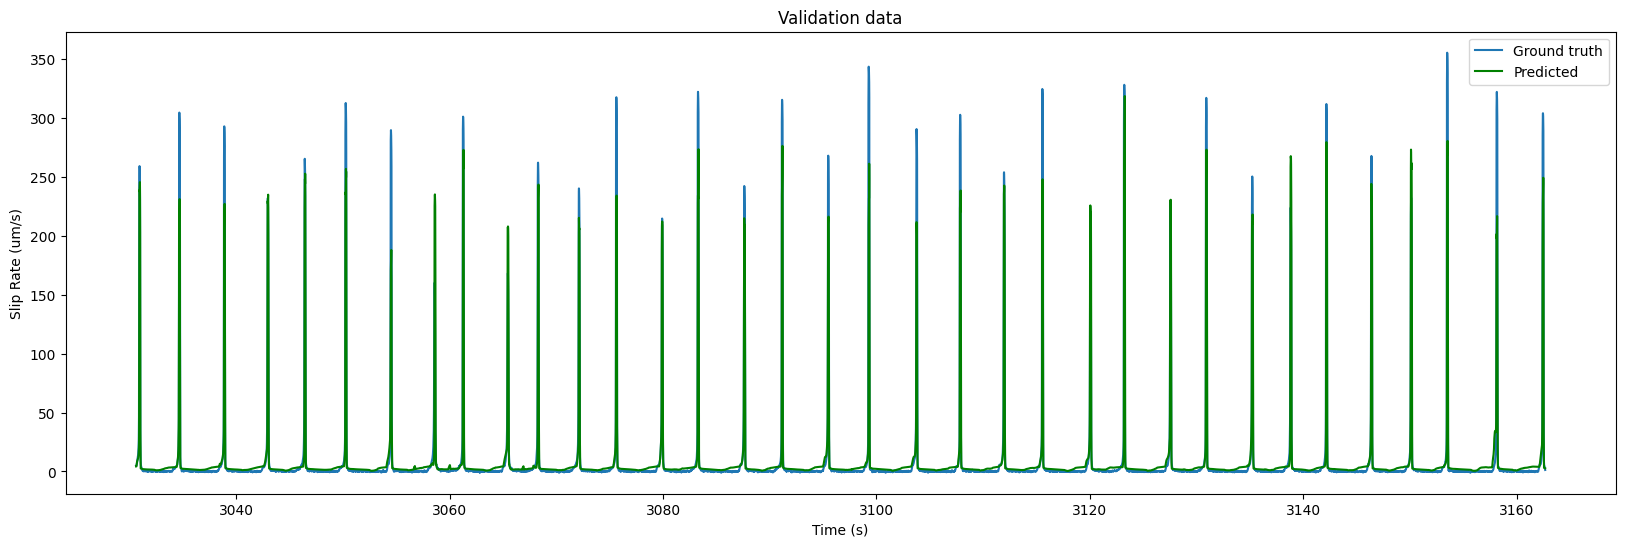

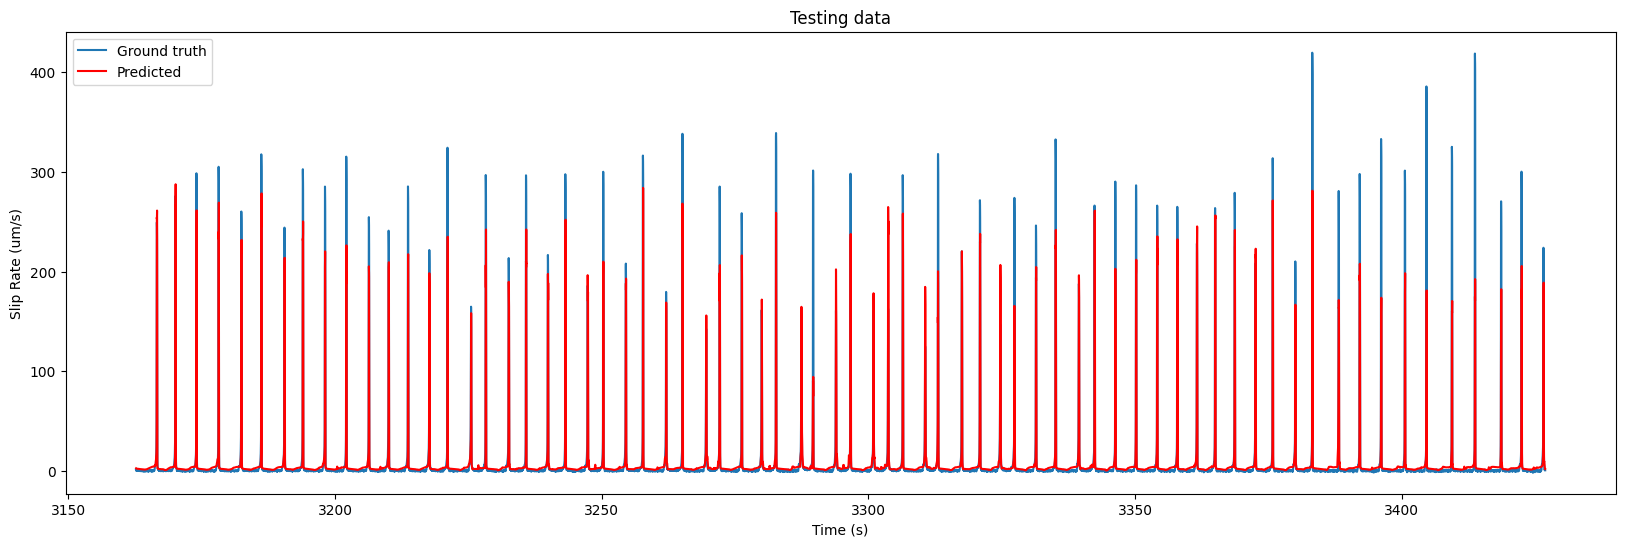

In [26]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [27]:
# Extract Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

kernel (600, 128)
bias (128,)
kernel (128, 64)
bias (64,)
kernel (64, 32)
bias (32,)
kernel (32, 16)
bias (16,)
kernel (16, 8)
bias (8,)
kernel (8, 1)
bias (1,)
kernel (8, 1)
bias (1,)
c1 ()
c2 ()
c3 ()
c4 ()
c5 ()
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)


In [28]:
# Display Weights
model.get_weights()

[array([[-8.6533442e-02,  6.2742293e-01, -6.6835321e-02, ...,
         -3.5051115e-02,  3.0904746e-01, -3.0212717e-02],
        [-1.3811268e-01,  5.8922833e-01, -5.4411986e-04, ...,
          9.9149691e-03,  1.2501894e-01, -4.4320084e-02],
        [-3.7860144e-02,  4.6202248e-01, -2.8981781e-02, ...,
          1.4260552e-02,  2.7356952e-01,  9.6094981e-02],
        ...,
        [-2.0899883e-02, -3.2417228e+00,  2.4470966e-02, ...,
         -2.2898583e-02,  1.9066280e-02,  4.1419119e-01],
        [-5.8385201e-02,  1.7682930e+00,  1.1272217e-01, ...,
         -3.2462939e-03, -3.0991740e+00, -2.9106838e-01],
        [ 3.3156332e-02, -3.4093332e+00, -3.7802566e-02, ...,
         -7.1190305e-02, -6.1951333e-01,  3.9053309e-01]], dtype=float32),
 array([ 0.0000000e+00,  1.0903648e+00, -6.5731937e-03,  3.1969121e-01,
         0.0000000e+00, -8.6973188e-03, -4.1508325e-03,  2.6785951e-02,
        -7.5626923e-03, -7.7842185e-03,  0.0000000e+00,  0.0000000e+00,
         2.6464555e-01, -5.1223901

In [29]:
# ML Learned Constants

# Normal Stress
r1 = 10/5.89
cols = ['NS']
data = pd.DataFrame(np.array([[2.74]]),columns=cols)
NS = scaler_ss.inverse_transform(data)
NS = NS*r1

# Shear Loading Velocity
dt = 0.01
cols = ['VL']
data = pd.DataFrame(np.array([[0.80]]),columns=cols)
VL = scaler_v.inverse_transform(data)
VL = (VL*dt)*2*r1

# Loading Stiffness
K = (((0.36)/10)/r1)*2

# Density (kg/cm3)
rho = (0.78*10*1000)/(2*r1)

print("Normal Stress:",NS)
print("Shear Loading Velocity:",VL)
print("Loading Stiffness:",K)
print("Density:",rho)
print("A_Intact:",20277)

Normal Stress: [[12.30539943]]
Shear Loading Velocity: [[9.44991406]]
Loading Stiffness: 0.042407999999999994
Density: 2297.1000000000004
A_Intact: 20277


In [30]:
# # Extract Data

# # Time
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')